In [1]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from palindrome import check_palindrome
# from tracr.haiku_to_pytorch import haiku_to_pytorch, apply
from haiku_to_pytorch_rg import haiku_to_pytorch


from dataloaders import makePalindromeDataLoader
from torchinfo import summary

In [3]:
loader = makePalindromeDataLoader()

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = check_palindrome()
# print(model.params)

import jax
print(jax.tree.map(lambda x: x.shape, model.params))

#double check if torch_model is right
torch_model = haiku_to_pytorch(model).to(DEVICE)

{'pos_embed': {'embeddings': (11, 93)}, 'token_embed': {'embeddings': (15, 93)}, 'transformer/layer_0/attn/key': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_0/attn/linear': {'b': (93,), 'w': (22, 93)}, 'transformer/layer_0/attn/query': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_0/attn/value': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_0/mlp/linear_1': {'b': (169,), 'w': (93, 169)}, 'transformer/layer_0/mlp/linear_2': {'b': (93,), 'w': (169, 93)}, 'transformer/layer_1/attn/key': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_1/attn/linear': {'b': (93,), 'w': (22, 93)}, 'transformer/layer_1/attn/query': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_1/attn/value': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_1/mlp/linear_1': {'b': (169,), 'w': (93, 169)}, 'transformer/layer_1/mlp/linear_2': {'b': (93,), 'w': (169, 93)}, 'transformer/layer_2/attn/key': {'b': (22,), 'w': (93, 22)}, 'transformer/layer_2/attn/linear': {'b': (93,), 'w': (22, 93)}, 'transformer/layer_2/attn/

In [5]:
import torch
import torch.nn.functional as F

# Define your vocab mapping (same as used to compile the Tracr model)
VOCAB = {"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"}
TOKEN_TO_ID = {t: i for i, t in enumerate(sorted(VOCAB))}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def tensorize_inputs(inputs, token_to_id, device):
    """Convert list of token sequences to padded LongTensor of IDs."""
    # Handle both batch of sequences or a single sequence
    if isinstance(inputs[0], str):
        inputs = [inputs]  # wrap single example in a batch
    max_len = max(len(seq) for seq in inputs)
    ids = [
        [token_to_id.get(tok, 0) for tok in seq] + [0] * (max_len - len(seq))
        for seq in inputs
    ]
    return torch.tensor(ids, dtype=torch.long, device=device)

def evaluate(model, data):
    inputs, outputs = data[0]

    # Convert inputs to tensor form
    inputs = tensorize_inputs(inputs, TOKEN_TO_ID, DEVICE)
    outputs = outputs.to(DEVICE)

    model_output = model(inputs)

    # Optional NaN debug check
    if torch.isnan(model_output).any():
        print("NaNs detected!")
        print("Inputs:", inputs)
        print("Outputs:", outputs)
        print("Model output:", model_output)

    loss = F.cross_entropy(model_output, outputs)
    return loss, {"logits": model_output}


In [6]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         1,023
├─Embedding: 1-1                         1,395
├─ModuleList: 1-2                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          8,343
│    │    └─TracrMLP: 3-2                31,696
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          8,343
│    │    └─TracrMLP: 3-4                31,696
│    └─TracrBlock: 2-3                   --
│    │    └─TracrAttention: 3-5          8,343
│    │    └─TracrMLP: 3-6                31,696
│    └─TracrBlock: 2-4                   --
│    │    └─TracrAttention: 3-7          8,343
│    │    └─TracrMLP: 3-8                31,696
Total params: 162,574
Trainable params: 162,574
Non-trainable params: 0

In [7]:
print(torch_model)

TracrTransformer(
  (token_embed): Embedding(15, 93)
  (layers): ModuleList(
    (0-3): 4 x TracrBlock(
      (attn): TracrAttention(
        (query): Linear(in_features=93, out_features=22, bias=True)
        (key): Linear(in_features=93, out_features=22, bias=True)
        (value): Linear(in_features=93, out_features=22, bias=True)
        (output): Linear(in_features=22, out_features=93, bias=True)
      )
      (mlp): TracrMLP(
        (linear1): Linear(in_features=93, out_features=169, bias=True)
        (linear2): Linear(in_features=169, out_features=93, bias=True)
      )
    )
  )
)


In [8]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some r

3.19


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 225.64it/s]


2.69


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 237.43it/s]


3.47


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 213.69it/s]


2.28


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 237.20it/s]


2.25


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 217.78it/s]


3.2


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 239.19it/s]


3.16


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 222.47it/s]


2.83


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 219.23it/s]

2.62


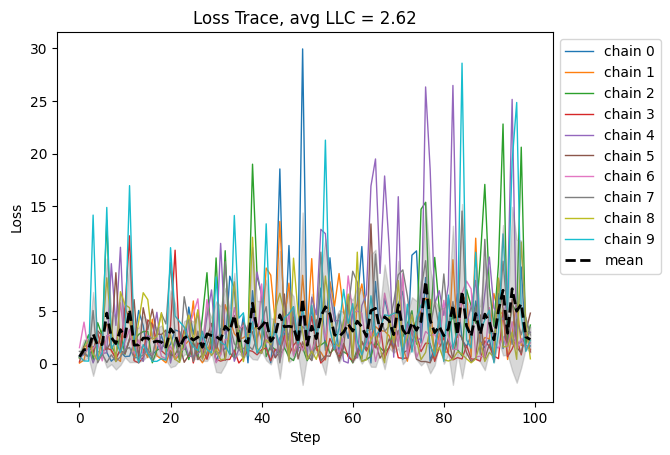

<Figure size 1200x900 with 0 Axes>

In [9]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)